In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os


import string
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer


import datetime
datetime.datetime.strptime

import preprocessor as p
import re

In [2]:
data = pd.read_csv('data/russia_201901_1_tweets_csv_hashed.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data = data[['tweetid', 'userid', 'user_display_name', 'user_screen_name',
       'user_reported_location', 'user_profile_description',
       'user_profile_url', 'follower_count', 'following_count',
       'account_creation_date', 'account_language', 'tweet_text', 'tweet_time', 'is_retweet']]

In [4]:
data.head(2)

,tweetid,userid,user_display_name,user_screen_name,user_reported_location,user_profile_description,user_profile_url,follower_count,following_count,account_creation_date,account_language,tweet_text,tweet_time,is_retweet
0,507097592116035584,TfAIZXAy2WKyIaMRGRo5Bc7TvYn5jid4HDIhZjHGuL0=,TfAIZXAy2WKyIaMRGRo5Bc7TvYn5jid4HDIhZjHGuL0=,TfAIZXAy2WKyIaMRGRo5Bc7TvYn5jid4HDIhZjHGuL0=,"New York, USA",Just another day on the job.,NaN,101,137,2013-08-26,tr,Follow your dreams.,2014-09-03 09:27,False
1,634855237140873217,aX+o4MEU0jsv3nWf6rkY9XdnJo+lUKxMZ3dB4rKPeIg=,aX+o4MEU0jsv3nWf6rkY9XdnJo+lUKxMZ3dB4rKPeIg=,aX+o4MEU0jsv3nWf6rkY9XdnJo+lUKxMZ3dB4rKPeIg=,"New York, USA",3 years ... Hardcore twitter fanatic #My stor...,NaN,56,94,2015-03-12,en,Ashley Madison stats find New Orleans among th...,2015-08-21 22:30,False


In [5]:
max(data.tweet_time)

'2018-11-06 18:04'

### Subsetting by prime interest time when seen most of posting activity

In [6]:
data['tweet_time'] = pd.to_datetime(data['tweet_time'])
start_date = '2014-01-01'
end_date = '2018-11-06'

mask = (data['tweet_time'] > start_date) & (data['tweet_time'] <= end_date)

data_prime = data.loc[mask]

In [7]:
type(data_prime)

pandas.core.frame.DataFrame

In [8]:
min(data_prime.tweet_time)

Timestamp('2014-01-04 00:44:00')

Take a quick look at some tweets.

How many tweets total?

In [9]:
len(data)

765246

In [10]:
### Retweets
retweets_mask = data_prime['is_retweet'] == True
retweets = data_prime[retweets_mask]

### Tweets
tweets_mask = data_prime['is_retweet'] == False
tweets = data_prime[tweets_mask]

#English Only
tweets_english = tweets[ tweets['account_language'] == 'en']
retweets_english = retweets[ retweets['account_language'] == 'en']



# For tests if needed

# toy_retweets_text = retweets['tweet_text'][:100 ]
# toy_retweets_df = retweets[:100]
# toy_tweets_df = tweets[:100]
# toy_tweets_text = tweets['tweet_text'][:100]

In [11]:
len(tweets_english.userid.unique())

331

In [12]:
min(tweets_english.tweet_time)

Timestamp('2014-01-04 00:44:00')

In [13]:
print( "english tweets:\t\t", len(tweets_english) )
print( "english retweets:\t", len(retweets_english) )

english tweets:		 159272
english retweets:	 591827


### Tweets Frequencies Timeseries. Monthly

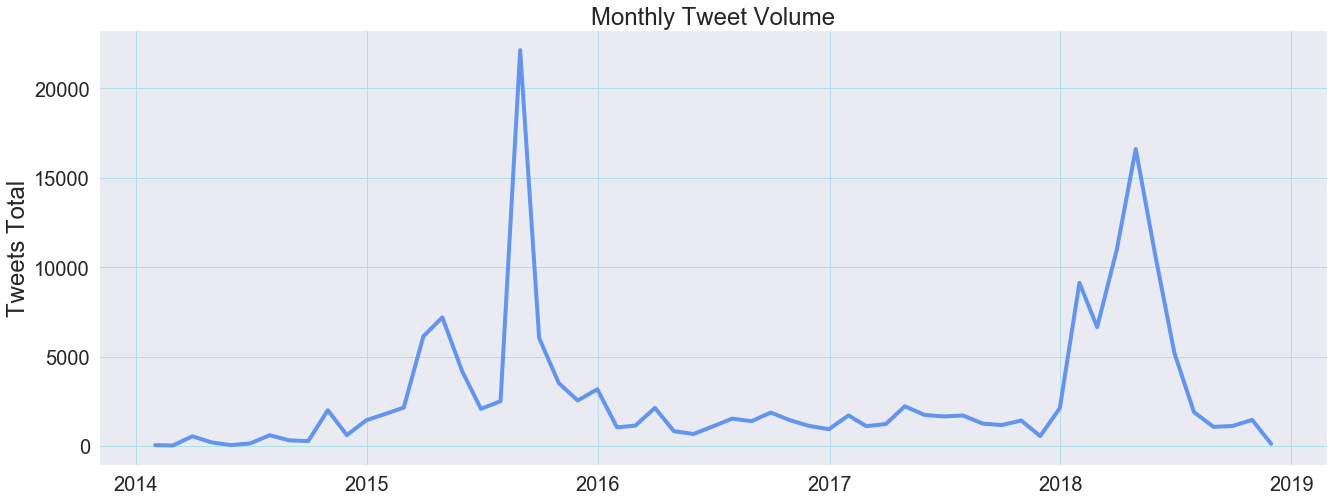

<Figure size 432x288 with 0 Axes>

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

# Number of Tweets Over Time
df_time = pd.DataFrame(pd.to_datetime( tweets["tweet_time"] ))

df_time["count"] = 1
df_time.set_index("tweet_time", inplace = True)

# hourly
hourly = df_time['count'].resample('H').sum()

# daily
daily = df_time.resample('D').sum()

# monthly
monthly = df_time['count'].resample('M').sum()



plt.figure(figsize=(22,8))

plt.plot(monthly,  c = 'cornflowerblue', linewidth=4.0)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Tweets Total', fontsize = 24)
plt.title('Monthly Tweet Volume', fontsize = 24)
plt.grid(c = 'powderblue')

plt.show()

plt.savefig('plots/monthly_tweet_volume.png')

In [15]:
em_data = pd.read_csv('data/andbrainDataSet108.csv')

In [16]:
# clean up the word column
em_data["word"] = em_data.word.str.strip().str.lower()

# remove duplicates
em_data = em_data.groupby('word').mean()

In [17]:
em_data.sample(3)

,disgust,surprise,neutral,anger,sad,happy,fear
word,,,,,,,
that,0.000003,0.000041,0.001251,0.000041,0.000047,0.000034,0.000028
panics,0.035714,0.035714,0.035714,0.035714,0.035714,0.035714,0.107143
invitations,0.035714,0.035714,0.035714,0.107143,0.035714,0.035714,0.035714


### Reading emotions set. Quickly preprocessing

In [18]:
em_data.head(5)

,disgust,surprise,neutral,anger,sad,happy,fear
word,,,,,,,
a,0.000004,0.000004,0.001425,0.000004,0.000004,0.000004,0.000004
aa,0.035714,0.035714,0.035714,0.107143,0.035714,0.035714,0.035714
aardvarkartglass,0.035714,0.107143,0.035714,0.035714,0.035714,0.035714,0.035714
aaron,0.017857,0.089286,0.017857,0.053571,0.017857,0.017857,0.017857
ab,0.011905,0.083333,0.011905,0.059524,0.011905,0.011905,0.011905


In [19]:
len(em_data)

23634

### Quick preprocessing of text in tweets

In [20]:
# def preprocessing_text(text):
#     '''
#     INPUT: str
#     OUTPUT: str w/ emojies, urls, hashtags and mentions removed
#     '''
#     p.set_options(p.OPT.EMOJI, p.OPT.URL, p.OPT.HASHTAG, p.OPT.MENTION, p.OPT.NUMBER)
#     clean_text = p.clean(text)
    
#     return clean_text

def remove_symbols(word, symbol_set):
    
    '''
    Removing symbols from word
    '''
    return ''.join(char for char in word 
                    if char not in symbol_set)


In [21]:
string.punctuation

punct = set(string.punctuation)
punct.remove('@')
punct.remove('#')
punct.add('🇺🇸')
punct.add('🤢')

lemmer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

tweets_english['tweet_text'] = tweets_english['tweet_text'].apply(lambda x: x.lower())
tweets_english['tweet_text'] = tweets_english['tweet_text'].apply(lambda x: remove_symbols(x, punct))
tweets_english['tweet_text'] = tweets_english['tweet_text'].apply(lambda x: re.sub(r'https?:\/\/.*\/\w*', '', x))
tweets_english['tweet_text'] = tweets_english['tweet_text'].apply(lambda x: lemmer.lemmatize(x))
tweets_english['tweet_text'] = tweets_english['tweet_text'].apply(lambda x: stemmer.stem(x))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-do

Take a quick look at the cleaned up tweets.

In [22]:
tweets_english.tweet_text.sample(3)

672782    omg i lost my sunglasses here hold them while ...
667829    @andy luv @bethenny amp wd luv 2 c her back on...
319623    #hillaryclinton #hillary2016 #hillarylies #hil...
Name: tweet_text, dtype: object

### Vectorizing tweets corpus over the set of words from em_dataset

In [23]:
# vocab = em_data.word.unique()

Here's our vocab.

In [24]:
# vocab[0:10]

In [25]:
# # making a vocabulary for vectorizer
# vocabulary= sorted(set(em_data.word))

In [26]:
# vocabulary[0:10]

In [27]:
# #Sklearn requires it to be a dictionary
# voc_dict = dict.fromkeys(vocabulary, 0)



In [28]:
vectorizer = CountVectorizer(stop_words='english', vocabulary = em_data.index)
vectorizer.fit(tweets_english.tweet_text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None,
        vocabulary=Index(['a', 'aa', 'aardvarkartglass', 'aaron', 'ab', 'aback', 'abagail',
       'abah', 'abandon', 'abandoned',
       ...
       'zoned', 'zones', 'zoning', 'zoo', 'zoom', 'zoomed', 'zooming',
       'zoophiliac', 'zoos', 'zouk'],
      dtype='object', name='word', length=23634))

In [29]:
X = vectorizer.transform(tweets_english.tweet_text)

In [30]:
X

<159272x23634 sparse matrix of type '<class 'numpy.int64'>'
	with 424393 stored elements in Compressed Sparse Row format>

In [31]:
X

<159272x23634 sparse matrix of type '<class 'numpy.int64'>'
	with 424393 stored elements in Compressed Sparse Row format>

In [32]:
# features are the words from em_set, and in this case our vocabulary
features = vectorizer.get_feature_names()
features[0:10]

['a',
 'aa',
 'aardvarkartglass',
 'aaron',
 'ab',
 'aback',
 'abagail',
 'abah',
 'abandon',
 'abandoned']

In [33]:

# # features are the words from em_set, and in this case our vocabulary
# features = vectorizer.get_feature_names()

# what problem I am solving
# What question are you answering
# What is you data?
# What's in your data
# What's is your approach to answering your questions?


# dense_x = X.toarray()

# # Making Pandas DataFrame w/vectorized words data and vocabulary as columns
# count_vectors = pd.DataFrame(data=dense_x, columns=vocabulary)
# count_vectors.head(1)

In [34]:
# count_vectors.shape

#### sorting Values alphabetically (set transition in count vectorizer made it into arbitrary ordered)

In [35]:
# count_vectors = count_vectors.reindex(sorted(count_vectors.columns), axis=1)

In [36]:
# count_vectors.head()

#### With a little pandas gymnastics we now match dimentions of 2 data frames. The reason we lost a few rows in count vectors is because countvectorizer vocabulary must be a **set** of unique words. 

In [37]:
# em_data = em_data.groupby('word').mean()

In [38]:
em_data.shape

(23634, 7)

In [39]:
(em_data.index == vectorizer.get_feature_names()).all()

True

In [40]:
em_data.values.shape

(23634, 7)

In [41]:
X.shape

(159272, 23634)

In [42]:
em_freq_np = X @ em_data.values

In [43]:
type(em_freq_np)

numpy.ndarray

In [44]:
em_freq_np.shape

(159272, 7)

In [45]:
em_freq_df = pd.DataFrame.from_records(em_freq_np)

In [46]:
em_freq_df.columns = em_data.columns

In [47]:
em_freq_df.head()

,disgust,surprise,neutral,anger,sad,happy,fear
0,0.097226,0.271829,0.098647,0.144845,0.236115,0.097226,0.113099
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.061261,0.114266,0.058528,0.102166,0.111456,0.262198,0.154196
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.012034,0.067158,0.012034,0.078804,0.073370,0.029891,0.072593


In [48]:
em_freq_df.shape

(159272, 7)

Histogram of happiness.

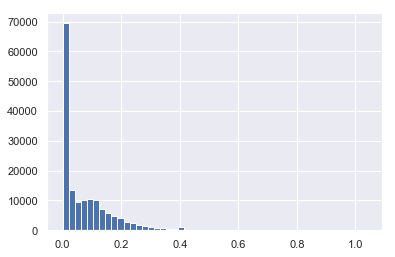

In [49]:
plt.hist( em_freq_np[:,5], bins=50 )
plt.show()

### Preparing Data for Plotting Time Series
1. Subsetting original set to only include timestamp and tweet text
2. Concatenating With Data Frame containing time data

In [50]:
tweet_time = (tweets_english[['tweet_text', 'tweet_time']]).reset_index(drop = True)


In [51]:
tweet_time.head(3), tweet_time.shape

(                                          tweet_text          tweet_time
 0  ashley madison stats find new orleans among th... 2015-08-21 22:30:00
 1                                  httptcon1xwcjhpr8 2015-04-13 18:04:00
 2  @nytimesworld two face scumbag listen up obama... 2017-01-13 03:17:00,
 (159272, 2))

In [52]:
emotions_frequencies = pd.concat([tweet_time, em_freq_df], axis = 1)
emotions_frequencies.head()


,tweet_text,tweet_time,disgust,surprise,neutral,anger,sad,happy,fear
0,ashley madison stats find new orleans among th...,2015-08-21 22:30:00,0.097226,0.271829,0.098647,0.144845,0.236115,0.097226,0.113099
1,httptcon1xwcjhpr8,2015-04-13 18:04:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,@nytimesworld two face scumbag listen up obama...,2017-01-13 03:17:00,0.061261,0.114266,0.058528,0.102166,0.111456,0.262198,0.154196
3,#inaugurationday #trumpinauguration #trumpismy...,2017-01-20 15:21:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,@michaelbarabaro fuckoff #losser #idiot #block...,2016-05-18 23:15:00,0.012034,0.067158,0.012034,0.078804,0.073370,0.029891,0.072593


### Plotting Emotion Detection Time Series

### Disgust

In [53]:
disgust= emotions_frequencies[['tweet_time', 'disgust' ]]
disgust.head(2)

,tweet_time,disgust
0,2015-08-21 22:30:00,0.097226
1,2015-04-13 18:04:00,0.000000


In [54]:
surprise= emotions_frequencies[['tweet_time', 'surprise' ]]
surprise.head(2)

,tweet_time,surprise
0,2015-08-21 22:30:00,0.271829
1,2015-04-13 18:04:00,0.000000


In [55]:
neutral= emotions_frequencies[['tweet_time', 'neutral' ]]
neutral.head(2)

,tweet_time,neutral
0,2015-08-21 22:30:00,0.098647
1,2015-04-13 18:04:00,0.000000


In [56]:
anger= emotions_frequencies[['tweet_time', 'anger' ]]
anger.head(2)


,tweet_time,anger
0,2015-08-21 22:30:00,0.144845
1,2015-04-13 18:04:00,0.000000


In [57]:
sad= emotions_frequencies[['tweet_time', 'sad' ]]
sad.head(2)

,tweet_time,sad
0,2015-08-21 22:30:00,0.236115
1,2015-04-13 18:04:00,0.000000


In [58]:
happy= emotions_frequencies[['tweet_time', 'happy' ]]
happy.head(2)

,tweet_time,happy
0,2015-08-21 22:30:00,0.097226
1,2015-04-13 18:04:00,0.000000


In [59]:
fear= emotions_frequencies[['tweet_time', 'fear' ]]
fear.head(2)

,tweet_time,fear
0,2015-08-21 22:30:00,0.113099
1,2015-04-13 18:04:00,0.000000


In [60]:
disgust_time = pd.DataFrame(pd.to_datetime( disgust["tweet_time"] ))
disgust_time['disgust'] = disgust['disgust']
disgust_time.set_index("tweet_time", inplace = True)
disgust_time.head(2)

,disgust
tweet_time,
2015-08-21 22:30:00,0.097226
2015-04-13 18:04:00,0.000000


In [61]:
surprise_time = pd.DataFrame(pd.to_datetime( surprise["tweet_time"] ))
surprise_time['surprise'] = surprise['surprise']
surprise_time.set_index("tweet_time", inplace = True)
surprise_time.head(2)

,surprise
tweet_time,
2015-08-21 22:30:00,0.271829
2015-04-13 18:04:00,0.000000


In [62]:
neutral_time = pd.DataFrame(pd.to_datetime( neutral["tweet_time"] ))
neutral_time['neutral'] = neutral['neutral']
neutral_time.set_index("tweet_time", inplace = True)
neutral_time.head(2)

,neutral
tweet_time,
2015-08-21 22:30:00,0.098647
2015-04-13 18:04:00,0.000000


In [63]:
anger_time = pd.DataFrame(pd.to_datetime( anger["tweet_time"] ))
anger_time['anger'] = anger['anger']
anger_time.set_index("tweet_time", inplace = True)
anger_time.head(2)


,anger
tweet_time,
2015-08-21 22:30:00,0.144845
2015-04-13 18:04:00,0.000000


In [64]:
sad_time = pd.DataFrame(pd.to_datetime( sad["tweet_time"] ))
sad_time['sad'] = sad['sad']
sad_time.set_index("tweet_time", inplace = True)
sad_time.head(2)

,sad
tweet_time,
2015-08-21 22:30:00,0.236115
2015-04-13 18:04:00,0.000000


In [65]:
happy_time = pd.DataFrame(pd.to_datetime( happy["tweet_time"] ))
happy_time['happy'] = happy['happy']
happy_time.set_index("tweet_time", inplace = True)
happy_time.head(2)

,happy
tweet_time,
2015-08-21 22:30:00,0.097226
2015-04-13 18:04:00,0.000000


In [66]:
fear_time = pd.DataFrame(pd.to_datetime( fear["tweet_time"] ))
fear_time['fear'] = fear['fear']
fear_time.set_index("tweet_time", inplace = True)
fear_time.head(2)

,fear
tweet_time,
2015-08-21 22:30:00,0.113099
2015-04-13 18:04:00,0.000000


### Monthly Emotions Detection. Cumulative. 

In [67]:

monthly_disgust = disgust_time['disgust'].resample('M').sum()

monthly_surprise = surprise_time['surprise'].resample('M').sum()

monthly_neutral = neutral_time['neutral'].resample('M').sum()

monthly_anger = anger_time['anger'].resample('M').sum()

monthly_sad = sad_time['sad'].resample('M').sum()

monthly_happy = happy_time['happy'].resample('M').sum()

monthly_fear = fear_time['fear'].resample('M').sum()


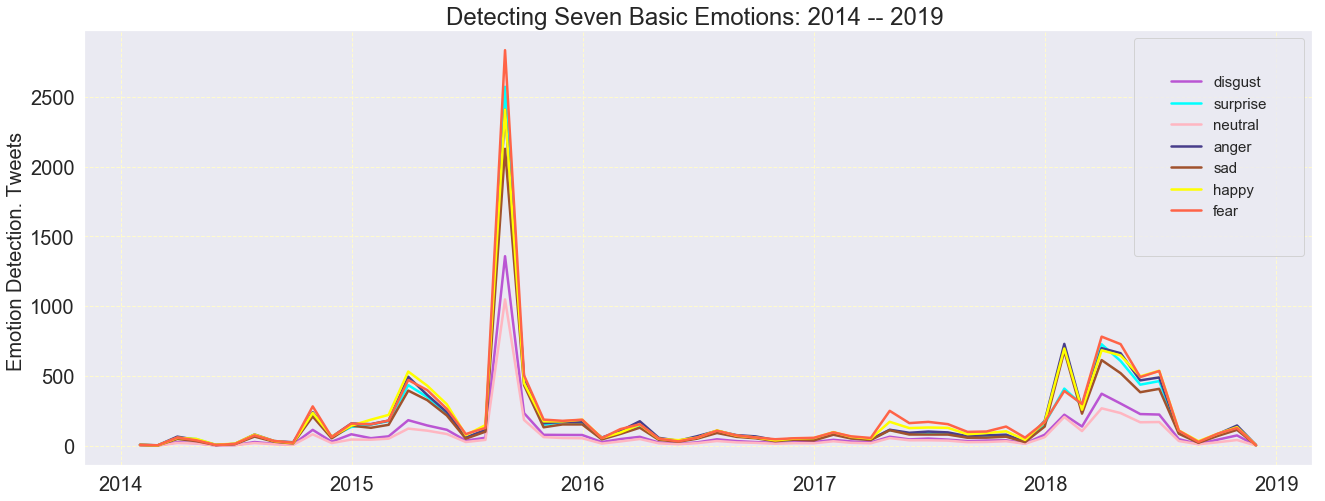

<Figure size 432x288 with 0 Axes>

In [68]:
plt.figure(figsize=(22,8))
sns.set(style="darkgrid")
plt.plot(monthly_disgust,  c = 'mediumorchid', linewidth=2.5, label = 'disgust')

plt.plot(monthly_surprise,  c = 'cyan', linewidth=2.5, label = 'surprise')
plt.plot(monthly_neutral,  c = 'lightpink', linewidth=2.5, label = 'neutral')
plt.plot(monthly_anger,  c = 'darkslateblue', linewidth=2.5, label = 'anger')
plt.plot(monthly_sad,  c = 'sienna', linewidth=2.5, label = 'sad')
plt.plot(monthly_happy,  c = 'yellow', linewidth=2.5, label = 'happy')
plt.plot(monthly_fear,  c = 'tomato', linewidth=2.5, label = 'fear')

plt.legend(borderpad=2.5, fontsize = 15, loc='upper right')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Emotion Detection. Tweets ', fontsize = 20)
plt.grid(c = 'lemonchiffon', linestyle = '--')
plt.title('Detecting Seven Basic Emotions: 2014 -- 2019 ', fontsize = 24)

plt.show()
plt.savefig('plots/monthly_tweet_volume.png')
# Emotional Composition of Tweets. 

In [69]:
norm_monthly_disgust = disgust_time['disgust'].resample('M').sum()/monthly

norm_monthly_surprise = surprise_time['surprise'].resample('M').sum()/monthly

norm_monthly_neutral = neutral_time['neutral'].resample('M').sum()/monthly

norm_monthly_anger = anger_time['anger'].resample('M').sum()/monthly

norm_monthly_sad = sad_time['sad'].resample('M').sum()/monthly

norm_monthly_happy = happy_time['happy'].resample('M').sum()/monthly

norm_monthly_fear = fear_time['fear'].resample('M').sum()/monthly


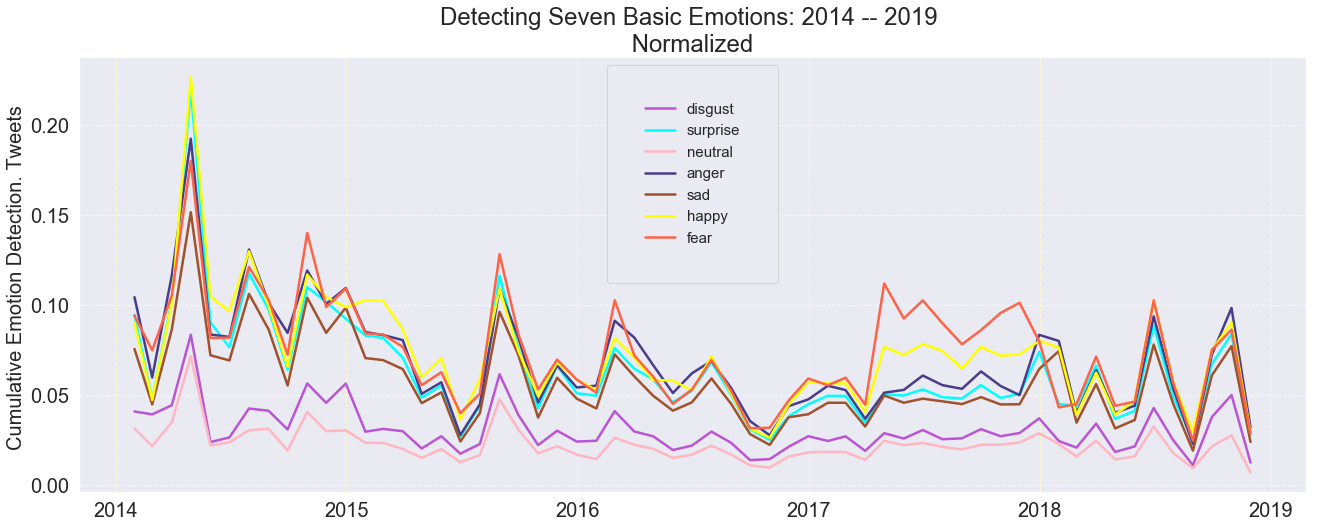

In [70]:
plt.figure(figsize=(22,8))
sns.set(style="darkgrid")
plt.plot(norm_monthly_disgust,  c = 'mediumorchid', linewidth=2.5, label = 'disgust')

plt.plot(norm_monthly_surprise,  c = 'cyan', linewidth=2.5, label = 'surprise')
plt.plot(norm_monthly_neutral,  c = 'lightpink', linewidth=2.5, label = 'neutral')
plt.plot(norm_monthly_anger,  c = 'darkslateblue', linewidth=2.5, label = 'anger')
plt.plot(norm_monthly_sad,  c = 'sienna', linewidth=2.5, label = 'sad')
plt.plot(norm_monthly_happy,  c = 'yellow', linewidth=2.5, label = 'happy')
plt.plot(norm_monthly_fear,  c = 'tomato', linewidth=2.5, label = 'fear')


plt.legend(borderpad=2.5, fontsize = 15, loc='upper center')
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Cumulative Emotion Detection. Tweets ', fontsize = 20)
plt.grid(c = 'lemonchiffon', linestyle = '--')
plt.title('Detecting Seven Basic Emotions: 2014 -- 2019 \n Normalized ', fontsize = 24)
plt.savefig('plots/norm_monthly_tweet_volume.png')

plt.show()

ValueError: need at least one array to concatenate

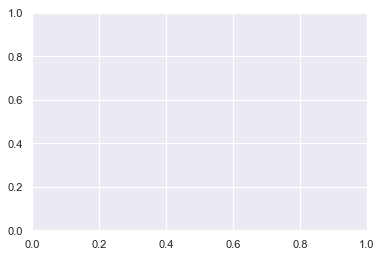

In [81]:


norm_month = [norm_monthly_disgust, norm_monthly_surprise, norm_monthly_neutral, norm_monthly_anger,
             norm_monthly_sad, norm_monthly_happy, norm_monthly_fear ]


x = [disgust_time.index, surprise_time.index, neutral_time.index, anger_time.index, sad_time.index, happy_time.index, fear_time.index]

plt.stackplot(x,y = norm_month, labels=['A','B','C', 'd', 'e', 'f', 'g'])

plt.figure(figsize=(22,8))
# sns.set(style="darkgrid")
# plt.plot(norm_monthly_disgust,  c = 'mediumorchid', linewidth=2.5, label = 'disgust')

# plt.plot(norm_monthly_surprise,  c = 'cyan', linewidth=2.5, label = 'surprise')
# plt.plot(norm_monthly_neutral,  c = 'lightpink', linewidth=2.5, label = 'neutral')
# plt.plot(norm_monthly_anger,  c = 'darkslateblue', linewidth=2.5, label = 'anger')
# plt.plot(norm_monthly_sad,  c = 'sienna', linewidth=2.5, label = 'sad')
# plt.plot(norm_monthly_happy,  c = 'yellow', linewidth=2.5, label = 'happy')
# plt.plot(norm_monthly_fear,  c = 'tomato', linewidth=2.5, label = 'fear')


# plt.legend(borderpad=2.5, fontsize = 15, loc='upper center')
# plt.xticks(fontsize = 20)
# plt.yticks(fontsize = 20)
# plt.ylabel('Cumulative Emotion Detection. Tweets ', fontsize = 20)
# plt.grid(c = 'lemonchiffon', linestyle = '--')
# plt.title('Detecting Seven Basic Emotions: 2014 -- 2019 \n Normalized ', fontsize = 24)
# # plt.savefig('plots/norm_monthly_tweet_volume.png')

# plt.show()

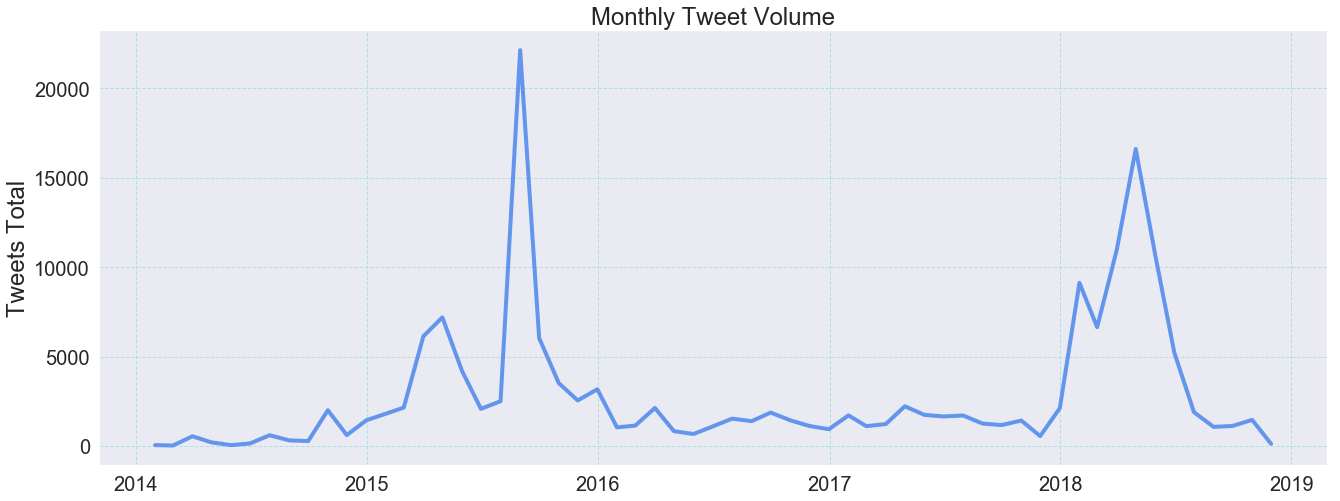

In [71]:
plt.figure(figsize=(22,8))

plt.plot(monthly,  c = 'cornflowerblue', linewidth=4.0)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.ylabel('Tweets Total', fontsize = 24)
plt.title('Monthly Tweet Volume', fontsize = 24)
plt.grid(c = 'powderblue', linestyle = '--')

plt.savefig('plots/tweet_volume.png')
plt.show()

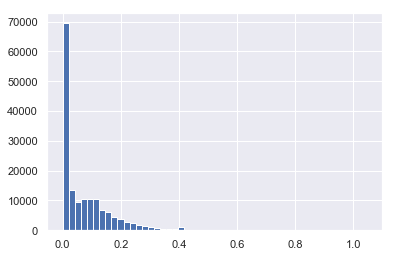

In [97]:
plt.hist( em_freq_np[:,5], bins=50 )
plt.show()

In [98]:
em_freq_np.shape
#percentege of emotion associated with tweet

(159272, 7)

In [99]:
import seaborn as sns

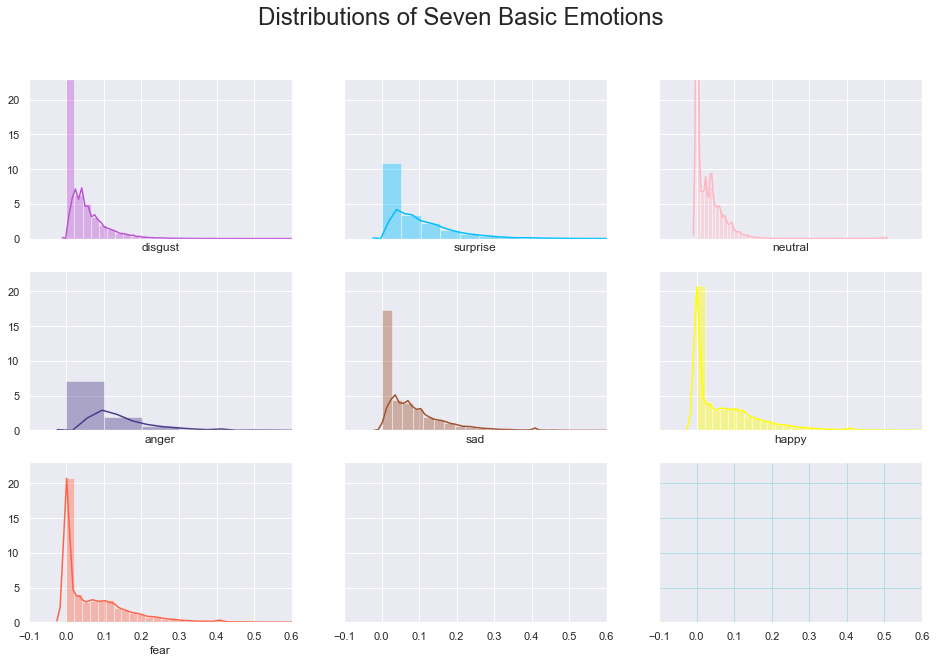

In [100]:
fig, axs = plt.subplots(nrows = 3, ncols = 3, figsize=(16,10), sharex=True, sharey=True)
fig.suptitle('Distributions of Seven Basic Emotions', fontsize = 24)


sns.set()


sns.distplot(em_freq_np[:,0], ax = axs[0, 0], bins = 50, axlabel = 'disgust', color='mediumorchid') 
sns.distplot(em_freq_np[:,1], ax = axs[0, 1], bins = 50, axlabel = 'surprise', color='deepskyblue')
sns.distplot(em_freq_np[:,2], ax = axs[0, 2], bins = 50, axlabel = 'neutral', color = 'lightpink')
sns.distplot(em_freq_np[:,3], ax = axs[1, 0], bins = 50, axlabel = 'anger', color = 'darkslateblue')
sns.distplot(em_freq_np[:,4], ax = axs[1, 1], bins = 50, axlabel = 'sad', color = 'sienna')
sns.distplot(em_freq_np[:,5], ax = axs[1, 2], bins = 50, axlabel = 'happy', color = 'yellow')
sns.distplot(em_freq_np[:,5], ax = axs[2, 0], bins = 50, axlabel = 'fear', color = 'tomato')


plt.grid(c = 'powderblue')
plt.ylim(0, 23)
plt.xlim(-0.1, 0.6)



plt.show()



#